# N-Body Quadtree Tutorial

In this tutorial, we will use the `NbodyQuadTree` class in `astroQTpy` to create a stability map of a two planet system using `REBOUND` (see full docs [here](https://rebound.readthedocs.io/en/latest/)). As a starting point, we will closely follow [this REBOUND example](https://rebound.readthedocs.io/en/latest/ipython_examples/Megno/), which implements the chaos indicator MEGNO (Mean Exponential Growth of Nearby Orbits) and the symplectic integrator WHFast (Rein and Tamayo 2015). Then, we will create the same stability map using a quadtree data structure implemented in `astrQTpy` to improve the code's performance.

### Generating a stability map by brute force

Following the `REBOUND` example linked above, we will integrate a system with two massive planets. We'll vary the semi-major axis $a$ (in AU) and the eccentricity $e$ on a fixed grid of 64x64 points, and run an N-body simulation at each point.

First, we need to define a function that runs one `REBOUND` simulation for a given set of initial conditions $(a, e)$, and returns the MEGNO value.

In [1]:
import rebound
import numpy as np

def megno_whfast_simulation(par):
    
    a, e = par # unpack parameters
    sim = rebound.Simulation()
    sim.integrator = "whfast"
    sim.ri_whfast.safe_mode = 0
    sim.dt = 5.
    sim.add(m=1.) # Star
    sim.add(m=0.000954, a=5.204, M=0.600, omega=0.257, e=0.048) # Planet inner
    sim.add(m=0.000285, a=a, M=0.871, omega=1.616, e=e) # Planet outer
    sim.move_to_com()
    
    sim.init_megno()
    sim.exit_max_distance = 20.
    
    try:
        sim.integrate(1e4 * 2.*np.pi, exact_finish_time=0) # integrate for 10000 years, integrating to the nearest
        # timestep for each output to keep the timestep constant and preserve WHFast's symplectic nature
        megno = sim.calculate_megno() 
        return megno
    
    except rebound.Escape:
        return 50. # At least one particle got ejected, returning large MEGNO.

Test out the function by running one simulation:

In [2]:
megno_whfast_simulation((7,0.1))

2.002831140643575

The returned MEGNO value in this case is about 2, which, according to the example linked above, indicates that the system is regular for these initial conditions.

Next, we'll run a larger array of simulations. For a fairer comparison, we'll run everything on just a single processor for now (though we could run multiple simulations in parallel for more computationally demanding simulations).

In [3]:
# define parameter grid
x_min, x_max = 7, 10  # semi-major axis
y_min, y_max = 0, 0.5  # eccentricity
Ngrid = 64

par_a = np.linspace(x_min, x_max, Ngrid)
par_e = np.linspace(y_min, y_max, Ngrid)

parameters = []
for e in par_e:
    for a in par_a:
        parameters.append((a, e))

In [4]:
# run all the simulations
results = list(map(megno_whfast_simulation, parameters))
results2d = np.array(results).reshape(Ngrid, Ngrid)

On a single core on my laptop, this takes approximately 35 seconds.

### Plot the stability map

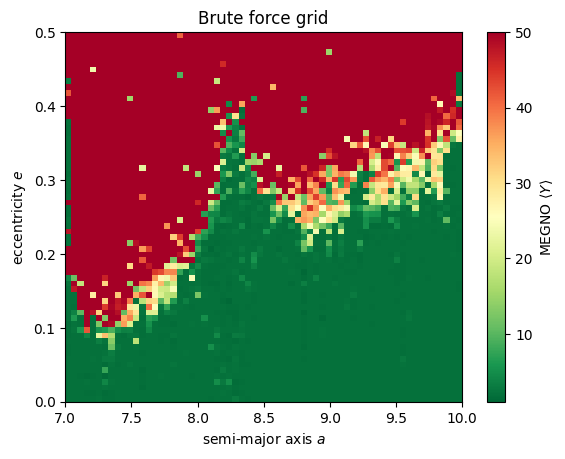

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.set_title('Brute force grid')

extent = [min(par_a),max(par_a),min(par_e),max(par_e)]
ax.set_xlim(extent[0],extent[1])
ax.set_xlabel("semi-major axis $a$")
ax.set_ylim(extent[2],extent[3])
ax.set_ylabel("eccentricity $e$")

im = ax.imshow(results2d, interpolation="none", vmin=1, vmax=50, cmap="RdYlGn_r", origin="lower", aspect='auto', extent=extent)
cb = plt.colorbar(im, ax=ax)
cb.set_label("MEGNO $\\langle Y \\rangle$"); 

The results look consistent with the [REBOUND example](https://rebound.readthedocs.io/en/latest/ipython_examples/Megno/)!

### Quadtree stability map with `astroQTpy`

Our stability map is a great example of something that can be optimized with a quadtree! For the brute force method, we ran an N-body simulation at every grid point, even in broad regions where the MENGO value was nearly uniform -- this is inefficient. Using a quadtree structure instead to compute our simulation grid should greatly reduce computational burden because we won't spend time computing extraneous model where the MEGNO value isn't changing much (i.e., the solid green and red areas in the plot above). With an `astroQTpy` quadtree, we will automatically explore a finer grid where the MEGNO value changes significantly, thereby improving our code's efficiency while preserving the "interesting" regions of parameter space where the system transitions from stable to unstable.

First, we need to import `NbodyQuadTree` from `astroQTpy`.

In [6]:
from astroqtpy.quadtree import NbodyQuadTree

Next we create an instance of `NbodyQuadTree`, passing arguments for the limits of the desired parameter space we defined earlier, and our function for running a `REBOUND` simulation.

We will further specify the split_threshold, which tells the code when it is appropriate to increase the grid resolution by splitting a node into four equal child nodes. In this example, we've set this value such that a node will split if the difference between its MEGNO value and one of its neighbors is greater than 0.5.

We will also only run a single simulation in each node, setting N_points to 1, although we may wish to run many simulations and average their MEGNO values together to improve the accuracy of our results. Finally, we'll set the maximum depth to 7, allowing for a maximum grid size of up to 64 x 64 (2^(7-1) = 64).

In [7]:
nbody_tree = NbodyQuadTree(x_min, x_max, y_min, y_max, megno_whfast_simulation,
                           split_threshold=0.5,
                           N_points=1,
                           max_depth=7,
                           filename_points='./tutorial_outputs/nbodytree_points.txt',
                           filename_nodes='./tutorial_outputs/nbodytree_nodes.txt'
                           )

Now run the quadtree!

In [8]:
nbody_tree.run_quadtree()

Attempting to load previous results...
   No previous results found, starting new...
DONE! :)


This time, the simluations only took about 20 seconds on a single core on my laptop!

### Plot the quadtree

Let's plot the results to check that we get a consistent stability map with our prior brute force method.

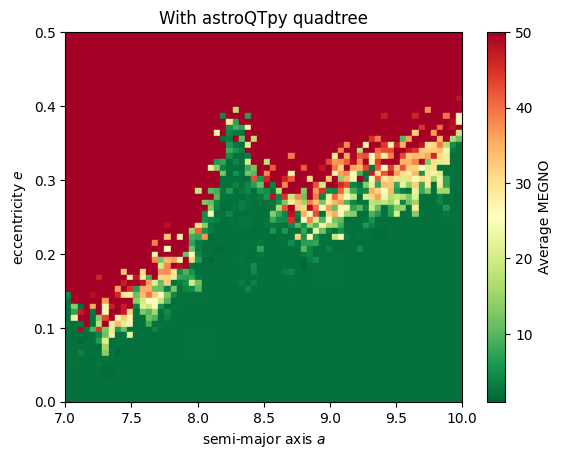

In [9]:
# make figure
fig, ax = plt.subplots()
ax.set_title('With astroQTpy quadtree')

ax.set_xlim(extent[0],extent[1])
ax.set_xlabel("semi-major axis $a$")
ax.set_ylim(extent[2],extent[3])
ax.set_ylabel("eccentricity $e$")

quadtree_map = nbody_tree.draw_tree(ax, vmin=1, vmax=50, show_lines=False)
plt.colorbar(quadtree_map, ax=ax, label='Average MEGNO'); 

Our results do appear to be consistent! While the improvement in runtime in this example is modest, we can expect much better performace compared to brute force mapping when simulations take longer to run or we want to compute many simulations within each node of the quadtree.

Finally, we can plot the quadtree map again, this time showing the node borders and simulation points to get a closer look at how this stability map is generated.

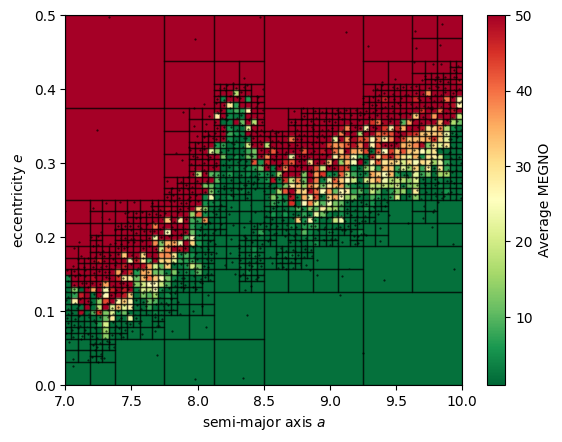

In [10]:
# make figure
fig, ax = plt.subplots()

ax.set_xlim(extent[0],extent[1])
ax.set_xlabel("semi-major axis $a$")
ax.set_ylim(extent[2],extent[3])
ax.set_ylabel("eccentricity $e$")

quadtree_map = nbody_tree.draw_tree(ax, vmin=1, vmax=50, show_lines=True, show_points=True)
plt.colorbar(quadtree_map, ax=ax, label='Average MEGNO'); 